In [0]:
import numpy as np

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

test_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

0it [00:00, ?it/s]

26427392it [00:02, 10332806.08it/s]                             


Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 73199.04it/s]                            
0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


4423680it [00:01, 3075232.03it/s]                            
0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


8192it [00:00, 24311.45it/s]            

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw
Processing...
Done!


In [0]:
from sklearn.model_selection import train_test_split

# unzip and split to train - validation data
features_train, targets_train = zip(*train_set)

X_train, X_val, y_train, y_val = train_test_split(features_train, targets_train)

In [0]:
# import DataLoader to split our dataset into batches
from torch.utils.data import DataLoader

train_data = DataLoader(list(zip(X_train, y_train)), batch_size=64, shuffle=True)
valid_data = DataLoader(list(zip(X_val, y_val)), batch_size=64, shuffle=True)

test_data = DataLoader(test_set, batch_size=64, shuffle=True)

# Lets first analyse our data

In [5]:
from collections import Counter

different_items = Counter()
for item in train_set.targets:
    different_items[int(item)] += 1

different_items

Counter({0: 6000,
         1: 6000,
         2: 6000,
         3: 6000,
         4: 6000,
         5: 6000,
         6: 6000,
         7: 6000,
         8: 6000,
         9: 6000})

So our data is well balanced

In [6]:
image, tgt = train_set[0]
print("One image shape", image.shape)

One image shape torch.Size([1, 28, 28])


# Lets try to set up a simple CNN and see what results we get

In [0]:
class simpleCNN(nn.Module):
    def __init__(self):
        super(simpleCNN, self).__init__()

        # original image dimension (28x28)

        # define conv (different architecures were tried)
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)

        # define pooling
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # define fc
        self.fc1 = torch.nn.Linear(16*7*7, 64)
        self.fc2 = torch.nn.Linear(64, 10)

        # Dropout
        self.drop = nn.Dropout(p=0.5)


    def forward(self, x):
        # do first pass
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.drop(x)

        # size changes from (3x28x28) --> (3x14x14)
        
        # perform one more conv step
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        # reshape our result to fit fc layer
        x = x.view(-1, 16*7*7)

        # get to fc layer
        x = torch.sigmoid(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        # x = nn.Softmax(self.fc2(x))

        
        return x

In [0]:
# use unsqueeze(0) in order to work with some random sample which is not in the
# format of DataSampler
# nn1 = simpleCNN()

set up Simple NN

In [0]:
import time

def train_NN(neuralNet, optimizer, loss_criterion, train_data, valid_data,
             save_name="NeuraNet.pt", epochs=50, print_loss=True, 
             change_lr: "decrease learning rate every n epochs" =False,
             seed=0):
    # epochs = 50
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

    best_accuracy = 0
    best_epoch = 1
    start_time = time.time()

    # loss_criterion = nn.MSELoss()
    # optimizer = optim.Adam(nn1.parameters(), lr=0.001)

    for e in range(1, epochs+1):
        print("Epoch: ", e)
        for i, batch in enumerate(train_data):
            features, targets = batch

            # change learning rate every int epochs
            if change_lr and e % change_lr == 0:
                for param_group in optimizer.param_groups:
                    param_group['lr'] /= 1.1

            optimizer.zero_grad()

            predictions = neuralNet.forward(features)

            # get one-hot targets
            one_hot = torch.zeros(len(predictions), 10)
            one_hot[torch.arange(len(predictions)), targets] = 1


            try:  # different losses require different formats
                loss = loss_criterion(predictions, one_hot)
            except RuntimeError:
                loss = loss_criterion(predictions, targets)

            loss.backward()
            optimizer.step()

            if i % 100 == 0 and print_loss:
                print("loss: ", loss)

        # by the end of the epoch check for the Validation set accuracy
        correct_num = 0
        total_instances = 0
        with torch.no_grad():
            for features, targets in valid_data:
                # make forward pass
                predictions_val = neuralNet.forward(features)

                # get prediction labels
                predictions_val = torch.argmax(predictions_val, axis=1)

                correct_num += int(sum(predictions_val == targets))
                total_instances += len(targets)

        valid_accuracy = correct_num/total_instances
        print("Accuracy on validation set: {0:.2f}%".format(valid_accuracy*100))

        if valid_accuracy > best_accuracy:
            best_accuracy = valid_accuracy
            best_epoch = e
            # save our NN
            torch.save(neuralNet.state_dict(), save_name)
        print("Time since the start: {0:.2f} min".format((time.time() - start_time)/60.0))
        print("============================================\n")

    print("Best accuracy: {0:.4f} was achieved at epoch {1}".format(best_accuracy*100, best_epoch)) 


In [0]:
def test_accuracy(nn, test_data=test_data):
    correct_num = 0
    total_instances = 0
    for features, targets in test_data:
            # make forward pass
            predictions_test = nn.forward(features)

            # get prediction labels
            predictions_test = torch.argmax(predictions_test, axis=1)

            correct_num += int(sum(predictions_test == targets))
            total_instances += len(targets)

    test_accuracy = correct_num/total_instances
    print("Accuracy on test set: {0:.2f}%".format(test_accuracy*100))

In [0]:
nn1 = simpleCNN()
train_NN(nn1, optimizer=optim.Adam(nn1.parameters(), lr=0.001),
         train_data=train_data, valid_data=valid_data,
         loss_criterion=nn.MSELoss(), save_name="simple_nn.pt", print_loss=False)

Validation accuracy is not too bad, but it would definitely not be good enough to achieve a good accuracy on the test set

First load the optimal model weights

In [0]:
nn1 = simpleCNN().to(device)
nn1.load_state_dict(torch.load("simple_nn.pt"))
nn1.eval()

simpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
)

In [0]:
test_accuracy(nn1)

Accuracy on test set: 91.42%


### Test accuracy: 91.42%

# Lets try some other architecture of CNN, and not do maxpooling after each conv layer




In [0]:
# this architecture achieves even better result
class secondCNN(nn.Module):
    def __init__(self, factor = 1):
        # "factor" allows to regulate # of channels
        self.factor = factor
        super(secondCNN, self).__init__()

        # original image dimension (28x28)

        # define conv (different architecures were tried)
        self.conv1_1 = torch.nn.Conv2d(in_channels=1, out_channels=16*factor, 
                                     kernel_size=3, stride=1, padding=1)
        
        self.conv1_2 = torch.nn.Conv2d(in_channels=16*factor, out_channels=16*factor, 
                                     kernel_size=3, stride=1, padding=1)
        
        self.conv2_1 = torch.nn.Conv2d(in_channels=16*factor, out_channels=32*factor, 
                                     kernel_size=3, stride=1, padding=1)
        
        self.conv2_2 = torch.nn.Conv2d(in_channels=32*factor, out_channels=32*factor, 
                                     kernel_size=3, stride=1, padding=1)

        # define pooling
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # define fc
        self.fc1 = torch.nn.Linear(32*factor*7*7, 512)
        self.fc2 = torch.nn.Linear(512, 10)

        # Dropout
        self.drop = nn.Dropout(p=0.5)

        # Batch Normalization
        self.normalize1 = nn.BatchNorm2d(16*factor) 
        self.normalize2 = nn.BatchNorm2d(32*factor) 



    def forward(self, x, pool=True, normalize=True):
        # do first pass
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))

        x = self.pool(x)
        if normalize:
            x = self.normalize1(x)
        x = self.drop(x)  # Dropout



        # second pass
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))

        x = self.pool(x)
        if normalize:
            x = self.normalize2(x)
        x = self.drop(x)  # Dropout

        # reshape our result to fit fc layer
        x = x.view(-1, 32*self.factor*7*7)  

        # get to fc layer
        x = torch.sigmoid(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        
        return x

In [0]:
nn2 = secondCNN(factor=2)
train_NN(nn2, optimizer=optim.Adam(nn2.parameters(), lr=0.001),
         train_data=train_data, valid_data=valid_data,
         loss_criterion=nn.MSELoss(), save_name="nn2.pt", epochs=50)

In [0]:
nn2 = secondCNN().to(device)
nn2.load_state_dict(torch.load("nn2.pt"))
nn2.eval()

test_accuracy(nn2)

### Test accuracy: 92.97%

# Data Augmentation
Accuracy increased! Perfect, but we are still not close to the main goal of 95% accuracy. Lets try to do some data Augmentation.

Lets try to extend our dataset by flipping the image horizontally

In [0]:
# # # Lets just check how to make the image to be flipped
# X_train, y_train
im1 = X_train[0]
im2 = torch.from_numpy(np.flip(im1.numpy(), axis=2).copy())

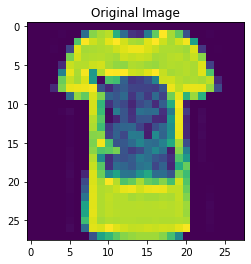

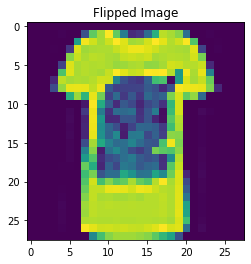

In [13]:
plt.imshow(im1[0])
plt.title("Original Image")
plt.show()

plt.imshow(im2[0])
plt.title("Flipped Image")
plt.show()

Now apply the same principle for our training set

In [0]:
X_train_extended = []
y_train_extended = []
np.random.seed(0)
for img, pred in zip(X_train, y_train):
    X_train_extended.append(img)
    y_train_extended.append(pred)

    # do random flips
    if np.random.randint(2) == 1:
        X_train_extended.append(torch.from_numpy(np.flip(img.numpy(), axis=2).copy()))
        y_train_extended.append(pred)

In [0]:
#  create Data Loader
train_data_extended = DataLoader(list(zip(X_train_extended, y_train_extended)), batch_size=64, shuffle=True)

# Best accuracy was achieved here

In [43]:
nn2 = secondCNN(factor=3)
train_NN(nn2, optimizer=optim.Adam(nn2.parameters(), lr=0.001),
         train_data=train_data_extended, valid_data=valid_data,
         loss_criterion=nn.MSELoss(), save_name="nn_extended.pt", epochs=50)

Epoch:  1
loss:  tensor(0.0900, grad_fn=<MseLossBackward>)
loss:  tensor(0.0261, grad_fn=<MseLossBackward>)
loss:  tensor(0.0189, grad_fn=<MseLossBackward>)
loss:  tensor(0.0154, grad_fn=<MseLossBackward>)
loss:  tensor(0.0195, grad_fn=<MseLossBackward>)
loss:  tensor(0.0124, grad_fn=<MseLossBackward>)
loss:  tensor(0.0204, grad_fn=<MseLossBackward>)
loss:  tensor(0.0139, grad_fn=<MseLossBackward>)
loss:  tensor(0.0204, grad_fn=<MseLossBackward>)
loss:  tensor(0.0175, grad_fn=<MseLossBackward>)
loss:  tensor(0.0184, grad_fn=<MseLossBackward>)
Accuracy on validation set: 88.41%
Time since the start: 7.87 min

Epoch:  2
loss:  tensor(0.0148, grad_fn=<MseLossBackward>)
loss:  tensor(0.0115, grad_fn=<MseLossBackward>)
loss:  tensor(0.0124, grad_fn=<MseLossBackward>)
loss:  tensor(0.0130, grad_fn=<MseLossBackward>)
loss:  tensor(0.0177, grad_fn=<MseLossBackward>)
loss:  tensor(0.0184, grad_fn=<MseLossBackward>)
loss:  tensor(0.0170, grad_fn=<MseLossBackward>)
loss:  tensor(0.0154, grad_fn=<

In [45]:
nn2 = secondCNN(factor=3).to(device)
nn2.load_state_dict(torch.load("nn_extended.pt"))
nn2.eval()

test_accuracy(nn2)

Accuracy on test set: 93.24%


Train for 50 more epochs with lower learning rate

In [16]:
nn2 = secondCNN(factor=3).to(device)
nn2.load_state_dict(torch.load("nn_extended.pt"))

train_NN(nn2, optimizer=optim.Adam(nn2.parameters(), lr=0.001/4),
         train_data=train_data_extended, valid_data=valid_data,
         loss_criterion=nn.MSELoss(), save_name="nn_extended_extra.pt", epochs=50)

Epoch:  1
loss:  tensor(0.0070, grad_fn=<MseLossBackward>)
loss:  tensor(0.0025, grad_fn=<MseLossBackward>)
loss:  tensor(0.0047, grad_fn=<MseLossBackward>)
loss:  tensor(0.0058, grad_fn=<MseLossBackward>)
loss:  tensor(0.0004, grad_fn=<MseLossBackward>)
loss:  tensor(0.0071, grad_fn=<MseLossBackward>)
loss:  tensor(0.0035, grad_fn=<MseLossBackward>)
loss:  tensor(0.0082, grad_fn=<MseLossBackward>)
loss:  tensor(0.0047, grad_fn=<MseLossBackward>)
loss:  tensor(0.0047, grad_fn=<MseLossBackward>)
loss:  tensor(0.0051, grad_fn=<MseLossBackward>)
Accuracy on validation set: 96.49%
Time since the start: 10.98 min

Epoch:  2
loss:  tensor(0.0093, grad_fn=<MseLossBackward>)
loss:  tensor(0.0046, grad_fn=<MseLossBackward>)
loss:  tensor(0.0003, grad_fn=<MseLossBackward>)
loss:  tensor(0.0101, grad_fn=<MseLossBackward>)
loss:  tensor(0.0024, grad_fn=<MseLossBackward>)
loss:  tensor(0.0027, grad_fn=<MseLossBackward>)
loss:  tensor(0.0032, grad_fn=<MseLossBackward>)
loss:  tensor(0.0033, grad_fn=

In [18]:
nn2 = secondCNN(factor=3).to(device)
nn2.load_state_dict(torch.load("nn_extended_extra.pt"))
nn2.eval()

test_accuracy(nn2)

Accuracy on test set: 94.79%


# Lets also try some other Loss fucntion: Cross Entropy

as MSE is usually used for regression

In [0]:
# torch.nn.CrossEntropyLoss()
nn3 = secondCNN()
train_NN(nn3, optimizer=optim.Adam(nn3.parameters(), lr=0.001),
         train_data=train_data_extended, valid_data=valid_data,
         loss_criterion=nn.CrossEntropyLoss(), save_name="nn3.pt")

Epoch:  1
loss:  tensor(2.3092, grad_fn=<NllLossBackward>)
loss:  tensor(1.7677, grad_fn=<NllLossBackward>)
loss:  tensor(1.7020, grad_fn=<NllLossBackward>)
loss:  tensor(1.6961, grad_fn=<NllLossBackward>)
loss:  tensor(1.6286, grad_fn=<NllLossBackward>)
loss:  tensor(1.6317, grad_fn=<NllLossBackward>)
loss:  tensor(1.6566, grad_fn=<NllLossBackward>)
loss:  tensor(1.5683, grad_fn=<NllLossBackward>)
loss:  tensor(1.5584, grad_fn=<NllLossBackward>)
loss:  tensor(1.6110, grad_fn=<NllLossBackward>)
loss:  tensor(1.5686, grad_fn=<NllLossBackward>)
Accuracy on validation set: 85.80%
Time since the start: 1.64 min

Epoch:  2
loss:  tensor(1.5537, grad_fn=<NllLossBackward>)
loss:  tensor(1.5839, grad_fn=<NllLossBackward>)
loss:  tensor(1.5879, grad_fn=<NllLossBackward>)
loss:  tensor(1.5512, grad_fn=<NllLossBackward>)
loss:  tensor(1.6156, grad_fn=<NllLossBackward>)
loss:  tensor(1.6586, grad_fn=<NllLossBackward>)
loss:  tensor(1.5711, grad_fn=<NllLossBackward>)
loss:  tensor(1.5867, grad_fn=<

In [0]:
nn3 = secondCNN().to(device)
nn3.load_state_dict(torch.load("nn3.pt"))
nn3.eval()

test_accuracy(nn3)

Accuracy on test set: 92.42%


# (best seen) Accuracy on test set: 92.42%

# also lets normalize original data by subtracting mean from the each image and dividing std deviation

In [0]:
X_train[0].shape

torch.Size([1, 28, 28])

In [0]:
stacked = torch.stack(X_train_extended, dim=0)

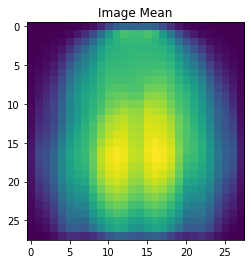

In [17]:
im_mean = torch.mean(stacked, axis=0)
im_std = torch.std(stacked, axis=0)
plt.imshow(im_mean[0])
plt.title("Image Mean")
plt.show()

Apply to extended version of the dataset, dont forget about normalizing validation and test sets

In [0]:
def normalize_data(X):
    norm = (torch.stack(X) - im_mean.unsqueeze(0))/ im_std.unsqueeze(0)

    return norm#.squeeze(1)

X_train_extended_norm = normalize_data(X_train_extended)

# dont forget to normalize the VALID 
X_val_norm = normalize_data(X_val)

# and TEST samples as well
features_test, targets_test = zip(*test_set)
X_test_norm = normalize_data(features_test)

In [0]:
# create data loader
train_data_extended_norm = DataLoader(list(zip(X_train_extended_norm, y_train_extended)), batch_size=64, shuffle=True)
valid_data_norm = DataLoader(list(zip(X_val_norm, y_val)), batch_size=64, shuffle=True)
test_data_norm = DataLoader(list(zip(X_test_norm, targets_test)), batch_size=64, shuffle=True)

In [0]:
# torch.nn.CrossEntropyLoss()
nn4 = secondCNN()
train_NN(nn4, optimizer=optim.Adam(nn4.parameters(), lr=0.001),
         train_data=train_data_extended_norm, valid_data=valid_data_norm,
         loss_criterion=nn.CrossEntropyLoss(), save_name="nn4.pt")

Epoch:  1
loss:  tensor(2.2978, grad_fn=<NllLossBackward>)
loss:  tensor(1.7075, grad_fn=<NllLossBackward>)
loss:  tensor(1.6883, grad_fn=<NllLossBackward>)
loss:  tensor(1.6559, grad_fn=<NllLossBackward>)
loss:  tensor(1.6538, grad_fn=<NllLossBackward>)
loss:  tensor(1.6331, grad_fn=<NllLossBackward>)
loss:  tensor(1.6490, grad_fn=<NllLossBackward>)
loss:  tensor(1.5723, grad_fn=<NllLossBackward>)
loss:  tensor(1.5820, grad_fn=<NllLossBackward>)
loss:  tensor(1.5635, grad_fn=<NllLossBackward>)
loss:  tensor(1.5857, grad_fn=<NllLossBackward>)
Accuracy on validation set: 85.55%
Time since the start: 1.76 min

Epoch:  2
loss:  tensor(1.5894, grad_fn=<NllLossBackward>)
loss:  tensor(1.5896, grad_fn=<NllLossBackward>)
loss:  tensor(1.5911, grad_fn=<NllLossBackward>)
loss:  tensor(1.5539, grad_fn=<NllLossBackward>)
loss:  tensor(1.6183, grad_fn=<NllLossBackward>)
loss:  tensor(1.6505, grad_fn=<NllLossBackward>)
loss:  tensor(1.5926, grad_fn=<NllLossBackward>)
loss:  tensor(1.6126, grad_fn=<

In [0]:
nn4 = secondCNN().to(device)
nn4.load_state_dict(torch.load("nn4.pt"))
nn4.eval()

test_accuracy(nn4, test_data=test_data_norm)

Accuracy on test set: 92.01%


In [24]:
nn5 = secondCNN().to(device)
nn5.load_state_dict(torch.load("nn5.pt"))
nn5.eval()

test_accuracy(nn5, test_data=test_data_norm)

Accuracy on test set: 90.49%
